# Benchmark for Community detection

In [2]:
"""Load/import helper functions"""

import time
import random
from LocalPopular import extract_labels_from_communities, time_tester, calculate_scores_CD

from LocalStable import locally_stable_clustering_with_hop_distance

from GraphFunctions import generate_agents, calculate_euclidian_relationships, create_graph, \
    my_make_circles, create_graphs_euclid, create_graphs_kNN, \
    generate_graph,create_graphs_hop_distance, create_graphs_hop_distance_abs,randomize_graph_node_labels

from PlotHelperFunctions import plot_clustering, plot_stuff

from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import make_moons
from sklearn.metrics import rand_score
import numpy as np
import networkx as nx
from scipy.spatial import distance

from community_detection.leiden import leiden
from community_detection.louvain import louvain
from community_detection.quality_functions import CPM, Modularity


import data.jazz as jazz
import data.cora as cora

## Create Graphs

In [3]:
repetitions = 1    #Number of random isomorph permutation for each graph

cora_graph = cora.get_graph()

cora_graph = nx.relabel_nodes(cora_graph, {list(cora_graph.nodes())[i] : i for i in range(len(cora_graph.nodes()))} )
cora_truth = list(cora_graph.nodes[i]['subject'] for i in range(len(cora_graph.nodes())))
cora_perm_graph = []
cora_perm_truth = []
for i in range(repetitions):
    g,t = randomize_graph_node_labels(cora_graph,cora_truth)
    cora_perm_graph += [g]
    cora_perm_truth += [t]


jazz_graph = jazz.get_graph()
jazz_graph = nx.relabel_nodes(jazz_graph, {i : i-1 for i in range(len(jazz_graph)+1)} )
jazz_graph,_ = randomize_graph_node_labels(jazz_graph,None)
jazz_truth = None

jazz_perm_graph = []
jazz_perm_truth = []
for i in range(repetitions):
    g,t = randomize_graph_node_labels(jazz_graph,jazz_truth)
    jazz_perm_graph += [g]
    jazz_perm_truth += [t]


karate_graph = nx.karate_club_graph()
#karate_graph,_ = randomize_graph_node_labels(karate_graph,None)
karate_truth = list(karate_graph.nodes[i]["club"] for i in range(34))

karate_perm_graph = []
karate_perm_truth = []
for i in range(repetitions):
    g,t = randomize_graph_node_labels(karate_graph,karate_truth)
    karate_perm_graph += [g]
    karate_perm_truth += [t]

karate_perm_graph = [karate_graph,karate_graph,karate_graph,karate_graph,karate_graph]
karate_perm_truth = [karate_truth,karate_truth,karate_truth,karate_truth,karate_truth]

graph,graph_truth = generate_graph(10,25,0.2,0.05)

graph_perm_graph = []
graph_perm_truth = []
for i in range(repetitions):
    g,t = randomize_graph_node_labels(graph,graph_truth)
    graph_perm_graph += [g]
    graph_perm_truth += [t]




## Run the algorithms


In [5]:
import itertools
import timeit

import pandas as pd
import numbers

dfs = []
labels = [(0.2,0.2), (0.25,0.35),(0.4,0.4)]

for treshold in labels:
    collected_data = {}
    for repetitions in range(10):
        f = treshold[0]   #f-bound
        e = treshold[1]   

        graphs = [karate_perm_graph,cora_perm_graph,jazz_perm_graph,graph_perm_graph]
        expected_clusters = [2,7,None,25]
        graph_names = [ 'Karate Club','Cora','Jazz','25 random communities']
        graph_truths =  [karate_perm_truth,cora_perm_truth,jazz_perm_truth,graph_perm_truth]
        
        
        𝓗 = Modularity(1.0)
        
        fn_louvain_mod = lambda G,_: louvain(G, 𝓗)
        fn_leiden_mod  = lambda G,_: leiden(G, 𝓗)
        
        louv_out = None
        lei_out = None
        
        algorithms = [ fn_louvain_mod, fn_leiden_mod]
        algo_names = [ 'Louvain (Mod)', 'Leiden (Mod)']
        
        lp_a_b =lambda agents, initial_clustering, pre, always_allow_exit: locally_stable_clustering_with_hop_distance(agents, f, e, initial_clustering,always_allow_exit,mode='B',pre=pre)
        lp_a_f =lambda agents, initial_clustering, pre, always_allow_exit: locally_stable_clustering_with_hop_distance(agents, f, e, initial_clustering, always_allow_exit, mode='F',pre=pre)
        lp_a_e =lambda agents, initial_clustering, pre, always_allow_exit: locally_stable_clustering_with_hop_distance(agents, f, e, initial_clustering, always_allow_exit, mode='E',pre=pre)
        
        
        algorithms = [ fn_louvain_mod, fn_leiden_mod,lp_a_b,lp_a_f,lp_a_e]
        algo_names = [ 'Louvain (Mod)', 'Leiden (Mod)','LS (Balanced) Heuristic',\
                       'LS (Friend-Oriented) Heuristic','LS (Enemy-Averse) Heuristic']
        is_lp_heuristic = [False,False,True, True, True]
        
        
        for ((graph, g_name,clusters,truth), (algo, a_name,lp_heuristic)) in \
            itertools.product(zip(graphs, graph_names, expected_clusters,graph_truths), zip(algorithms, algo_names,is_lp_heuristic)):
            
                
                
            agents = []
            for i in range(len(graph)):
                agents += [list(graph[i].nodes())]
    
    
            if lp_heuristic:
                # start with everyone alone
                a_name_modified = a_name + ' starting with everyone alone'
                initial_clusters = len(agents[0])
                if graph == cora_perm_graph:
                    a_name_modified += ' *6 starting clusters'
                    initial_clusters = 6
                print(f"Running {a_name_modified} on {g_name} … ", end='')
                
                always_allow_exit = False
                test_callable = lambda a: algo(a,initial_clusters,None,always_allow_exit)
                times,outputs = time_tester(test_callable,graph)
                avg_time = sum(times)/len(times)
                scores = calculate_scores_CD(outputs,truth,graph)
                scores['Time'] = avg_time
        
                if (a_name_modified, g_name) not in collected_data:
                    collected_data[(a_name_modified, g_name)] = []
                collected_data[(a_name_modified, g_name)].append(scores)
                print(f"execution time: ~ {avg_time:.6f} seconds.")
                for score_name in scores.keys():
                    print(score_name,": ~",scores.get(score_name))
        
                
                # starting with predicted number of clusters
                a_name_modified = a_name + ' starting with predicted number of clusters'
                initial_clusters = clusters
                print(f"Running {a_name_modified} on {g_name} … ", end='')
        
                always_allow_exit = False
                test_callable = lambda a: algo(a,initial_clusters,None,always_allow_exit)
                times,outputs = time_tester(test_callable,graph)
                avg_time = sum(times)/len(times)
                scores = calculate_scores_CD(outputs,truth,graph)
                scores['Time'] = avg_time
    
                if (a_name_modified, g_name) not in collected_data:
                    collected_data[(a_name_modified, g_name)] = []
                collected_data[(a_name_modified, g_name)].append(scores)
                print(f"execution time: ~ {avg_time:.6f} seconds.")
                for score_name in scores.keys():
                    print(score_name,": ~",scores.get(score_name))
        
                
                # start with the output of leiden
                a_name_modified = a_name + ' starting with the output of leiden'
                initial_clusters = clusters
                print(f"Running {a_name_modified} on {g_name} … ", end='')
        
                always_allow_exit = False
                test_callable = lambda a: algo(a,initial_clusters,fn_leiden_mod,always_allow_exit)
                times,outputs = time_tester(test_callable,graph)
                avg_time = sum(times)/len(times)
                scores = calculate_scores_CD(outputs,truth,graph)
        
                rand_score_with_init = sum(rand_score(list(out.values()), list(lei.values())) for out, lei in zip(outputs, lei_output)) / len(outputs)
                scores['Rand Score with initial clustering'] = rand_score_with_init
                
                scores['Time'] = avg_time
        
                if (a_name_modified, g_name) not in collected_data:
                    collected_data[(a_name_modified, g_name)] = []
                collected_data[(a_name_modified, g_name)].append(scores)
                print(f"execution time: ~ {avg_time:.6f} seconds.")
                for score_name in scores.keys():
                    print(score_name,": ~",scores.get(score_name))
    
           
    
            else:
                print(f"Running {a_name} on {g_name} … ", end='')
                test_callable = lambda a : algo(a,_)
                times,outputs = time_tester(test_callable,graph)
                outputs = [extract_labels_from_communities(c.communities) for c in outputs]
        
                if algo == fn_leiden_mod:
                    lei_output = outputs
                    
                
                avg_time = sum(times)/len(times)
                scores = calculate_scores_CD(outputs,truth,graph)
                scores['Time'] = avg_time
                if (a_name, g_name) not in collected_data:
                    collected_data[(a_name, g_name)] = []
                collected_data[(a_name, g_name)].append(scores)
                print(f"execution time: ~ {avg_time:.6f} seconds.")
                for score_name in scores.keys():
                    print(score_name,": ~",scores.get(score_name))

    records = []

    for (method, dataset), metrics_list in collected_data.items():
        record = {'Method': method, 'Dataset': dataset}
        keys = metrics_list[0].keys()
        for key in keys:
            # check if this metric is numeric
            if isinstance(metrics_list[0][key], numbers.Number):
                values = [m[key] for m in metrics_list]
                mean = sum(values) / len(values)
                std = (sum((v - mean) ** 2 for v in values) / len(values)) ** 0.5
                record[key] = (mean, std)
            else:
                # if not numeric (e.g., a string), just copy one of them
                record[key] = metrics_list[0][key]
        records.append(record)
    
    df = pd.DataFrame(records)
    
    dfs.append(df)

dfs[0].head()


Running Louvain (Mod) on Karate Club … execution time: ~ 0.013835 seconds.
Rand Index : ~ 0.6770053475935829
Modularity : ~ 0.4409156500065591
Time : ~ 0.013834500002849382
Running Leiden (Mod) on Karate Club … execution time: ~ 0.021051 seconds.
Rand Index : ~ 0.6770053475935829
Modularity : ~ 0.44110680084706055
Time : ~ 0.021050600000307895
Running LS (Balanced) Heuristic starting with everyone alone on Karate Club … execution time: ~ 0.011345 seconds.
Rand Index : ~ 0.5525846702317291
Modularity : ~ 0.20661157024793392
Time : ~ 0.011344960001588333
Running LS (Balanced) Heuristic starting with predicted number of clusters on Karate Club … execution time: ~ 0.003264 seconds.
Rand Index : ~ 0.5294117647058824
Modularity : ~ 0.2790708569929349
Time : ~ 0.0032641799974953757
Running LS (Balanced) Heuristic starting with the output of leiden on Karate Club … execution time: ~ 0.027852 seconds.
Rand Index : ~ 0.7005347593582888
Modularity : ~ 0.42955529319165675
Rand Score with initial c

,Method,Dataset,Rand Index,Modularity,Time,Rand Score with initial clustering
0,Louvain (Mod),Karate Club,"(0.666951871657754, 0.015113341867324813)","(0.44137328760705385, 0.0021579184189107928)","(0.010626072000304703, 0.0014289856769843067)",NaN
1,Leiden (Mod),Karate Club,"(0.6750445632798574, 0.007166130124865622)","(0.43981465864582747, 0.0032288792023366882)","(0.020856972000328825, 0.0018474412905056506)",NaN
2,LS (Balanced) Heuristic starting with everyone...,Karate Club,"(0.5525846702317291, 0.0)","(0.20661157024793392, 0.0)","(0.011565306000120472, 0.0008793547691732557)",NaN
3,LS (Balanced) Heuristic starting with predicte...,Karate Club,"(0.5294117647058824, 0.0)","(0.2790708569929349, 0.0)","(0.0031999919995723755, 0.0004437626817196938)",NaN
4,LS (Balanced) Heuristic starting with the outp...,Karate Club,"(0.7011764705882354, 0.0018715728696479953)","(0.4290935327298963, 0.0008462289731155057)","(0.02440027000004193, 0.001905009995373657)","(0.6944385026737969, 0.004258571108590552)"


## Gather the numbers

We can use the collected_data dictionary to build a table for better comparison


In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D

plt.rcParams.update({'font.size': 18})

def plot_custom_thresholds_with_louvain_leiden(dfs, labels, dataset_name, score_col='Rand Index'):
    # Add threshold column to each DataFrame
    for df, label in zip(dfs, labels):
        df['Threshold'] = str(label)  # make sure label is string for plotting

    # Combine all datasets
    df_all = pd.concat(dfs)

    # Filter for selected dataset
    df_all = df_all[df_all['Dataset'] == dataset_name].copy()

    # Add method group
    def method_group(row):
        m = row['Method']
        if 'everyone alone' in m:
            return 'LocStab-S'
        elif 'predicted number of clusters' in m:
            return 'LocStab-P'
        elif 'output of leiden' in m:
            return 'LocStab-Ld'
        elif 'louvain' in m.lower():
            return 'Louvain'
        elif 'leiden' in m.lower():
            return 'Leiden'
        else:
            return 'Other'

    def variant_label(row):
        m = row['Method']
        if 'Enemy-Averse' in m:
            return 'AE'
        elif 'Balanced' in m:
            return 'B'
        elif 'Friend-Oriented' in m:
            return 'AF'
        else:
            return 'Other'

    df_all['method_group'] = df_all.apply(method_group, axis=1)
    df_all['variant'] = df_all.apply(variant_label, axis=1)

    # Define order and positions
    method_order = ['Louvain', 'Leiden', 'LocStab-S', 'LocStab-P',
                    'LocStab-Ld']
    method_pos = {method: i for i, method in enumerate(method_order)}

    variant_colors = {
        'B': 'green',
        'AF': 'orange',
        'AE': 'blue'
    }
    threshold_markers = {
        str(labels[0]): '^',
        str(labels[1]): 'o',
        str(labels[2]): 's'
    }
    variant_offset = {
        'AF': -0.2,
        'B': 0.0,
        'AE': 0.2
    }

    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot LP heuristics
    for method in method_order[2:]:  # skip Leiden/Louvain
        for variant in ['B', 'AF', 'AE']:
            for threshold in threshold_markers.keys():
                sub_df = df_all[
                    (df_all['method_group'] == method) &
                    (df_all['variant'] == variant) &
                    (df_all['Threshold'] == threshold)
                ]
                if sub_df.empty:
                    continue

                x_pos = method_pos[method] + variant_offset[variant] + 2
                means = sub_df[score_col].apply(lambda x: float(x[0]) if not pd.isna(x[0]) else np.nan).values
                stds = sub_df[score_col].apply(lambda x: float(x[1]) if not pd.isna(x[1]) else np.nan).values

                ax.scatter(
                    [x_pos] * len(means), means,
                    color=variant_colors[variant],
                    marker=threshold_markers[threshold],
                    s=80, edgecolor='black', alpha=0.8,
                    label=f'{variant} - {threshold}' if (threshold == str(labels[0])) else None
                )

                # Plot 2-sigma error bars
                for mean, std in zip(means, stds):
                    ax.plot(
                        [x_pos, x_pos],
                        [mean - 2*std, mean + 2*std],
                        color=variant_colors[variant],
                        alpha=0.4,
                        linewidth=1
                    )

    # Plot Leiden and Louvain averages
    for method in ['Leiden', 'Louvain']:
        if method not in method_pos:
            continue  # skip if method not recognized
    
        sub_df = df_all[df_all['method_group'] == method]
        if sub_df.empty or sub_df[score_col].isna().all():
            continue  # skip if no valid scores
    
        y_vals = [val[0] for val in sub_df[score_col].dropna().values]
        y_stds = [val[1] for val in sub_df[score_col].dropna().values]
    
        avg = np.mean(y_vals)
        std = np.sqrt(np.mean([s**2 for s in y_stds]))
    
        ax.scatter(
            method_pos[method] + 2, avg,
            color='black', marker='o', s=80, edgecolor='white',
            label=None
        )
    
        ax.errorbar(
            method_pos[method] + 2, avg,
            yerr=2*std,
            fmt='none',
            ecolor='black',
            elinewidth=1,
            capsize=3,
            alpha=0.6
        )

    ax.set_xticks(range(2, len(method_order)+2))
    ax.set_xticklabels(method_order, rotation=90)
    ax.set_ylabel(score_col)
    ax.set_title(f'{score_col} by Method on {dataset_name}')
    ax.grid(True, axis='y', linestyle='--', alpha=0.6)

    # Color legend
    color_legend = [
        Line2D([0], [0], marker='o', color='w', label=v, markerfacecolor=c, markersize=10, markeredgecolor='black')
        for v, c in variant_colors.items()
    ]
    shape_legend = [
        Line2D([0], [0], marker=m, color='w', label=thresh, markerfacecolor='gray', markersize=10, markeredgecolor='black')
        for thresh, m in threshold_markers.items()
    ]

    # Adjust legend position
    plt.legend(
        handles=color_legend + shape_legend, 
        title='', 
        loc='upper right',
        bbox_to_anchor=(1.28, 1),
        borderaxespad=0.5,
        fontsize=16,
        ncol=1
    )
    #plt.ylim(0,1.1)
    plt.tight_layout()
    plt.xticks(rotation=10)
    plt.subplots_adjust(right=0.75)

    return fig, ax


Figure saved as /Users/User/Downloads/local-popular-main-final/noylim/Stable/community/Karate Club-Rand Index.png


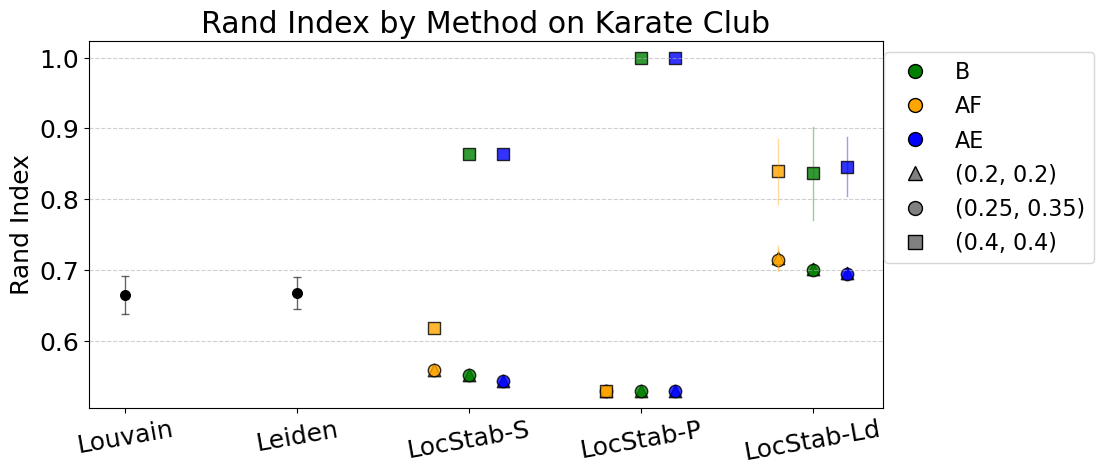

Figure saved as /Users/User/Downloads/local-popular-main-final/noylim/Stable/community/Karate Club-Modularity.png


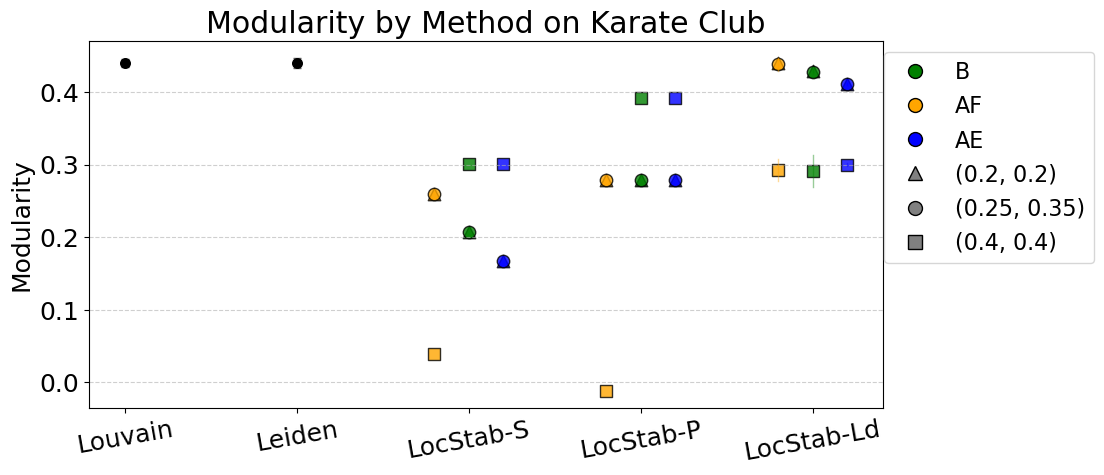

Figure saved as /Users/User/Downloads/local-popular-main-final/noylim/Stable/community/Jazz-Rand Index.png


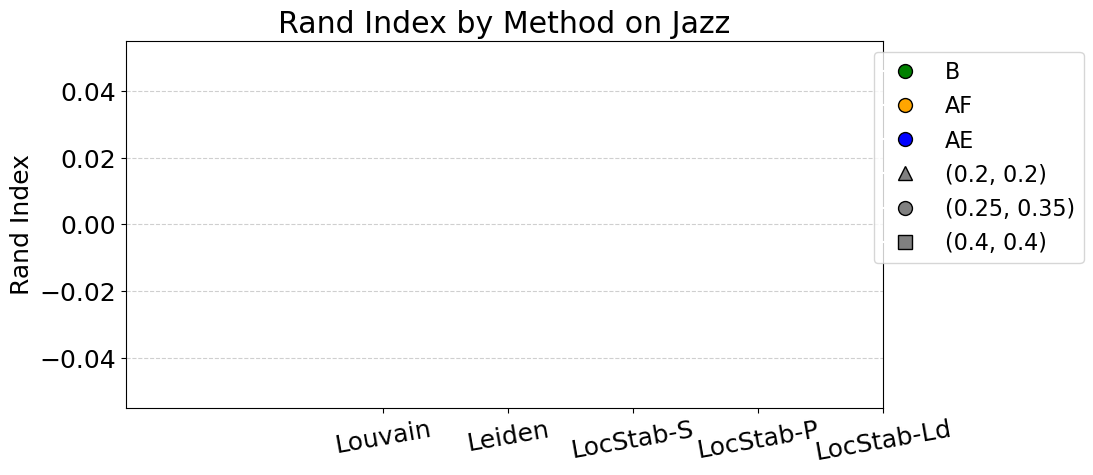

Figure saved as /Users/User/Downloads/local-popular-main-final/noylim/Stable/community/Jazz-Modularity.png


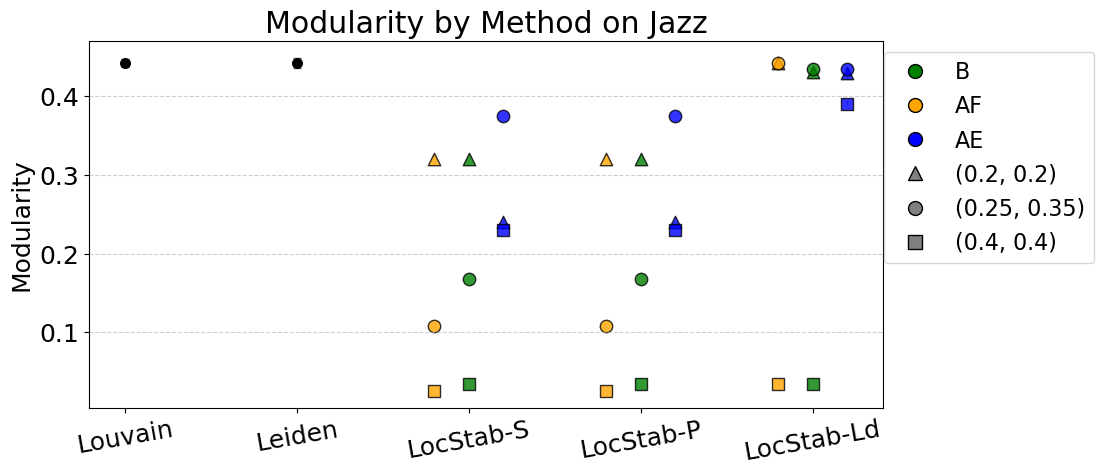

Figure saved as /Users/User/Downloads/local-popular-main-final/noylim/Stable/community/Cora-Rand Index.png


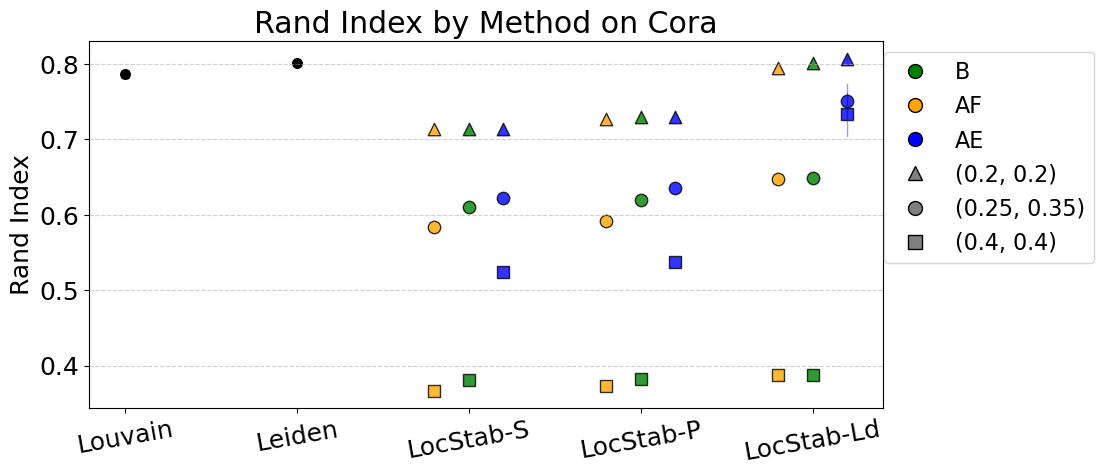

Figure saved as /Users/User/Downloads/local-popular-main-final/noylim/Stable/community/Cora-Modularity.png


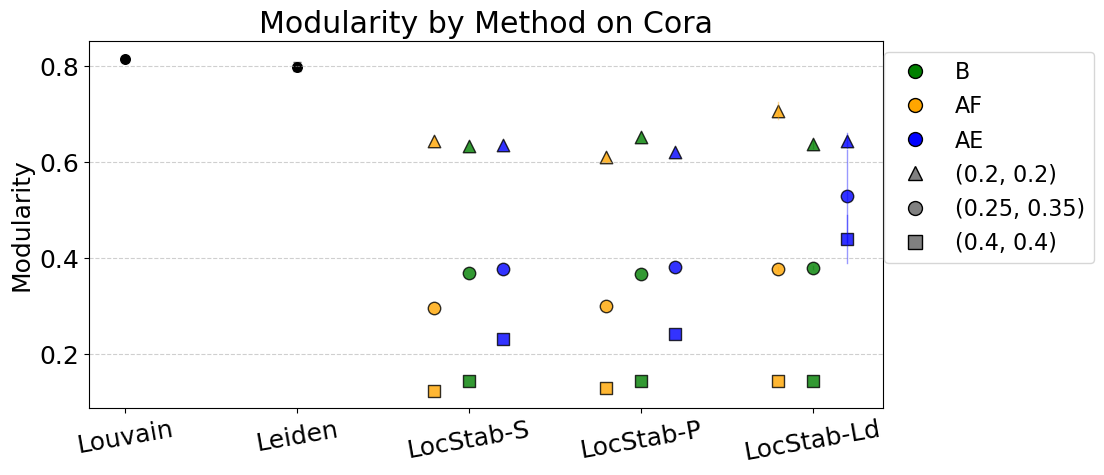

Figure saved as /Users/User/Downloads/local-popular-main-final/noylim/Stable/community/Random-25-Rand Index.png


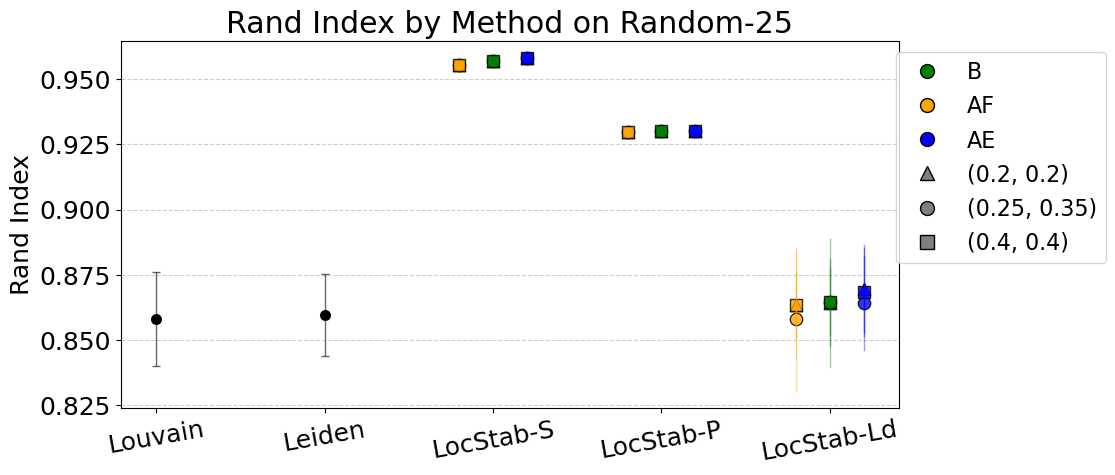

Figure saved as /Users/User/Downloads/local-popular-main-final/noylim/Stable/community/Random-25-Modularity.png


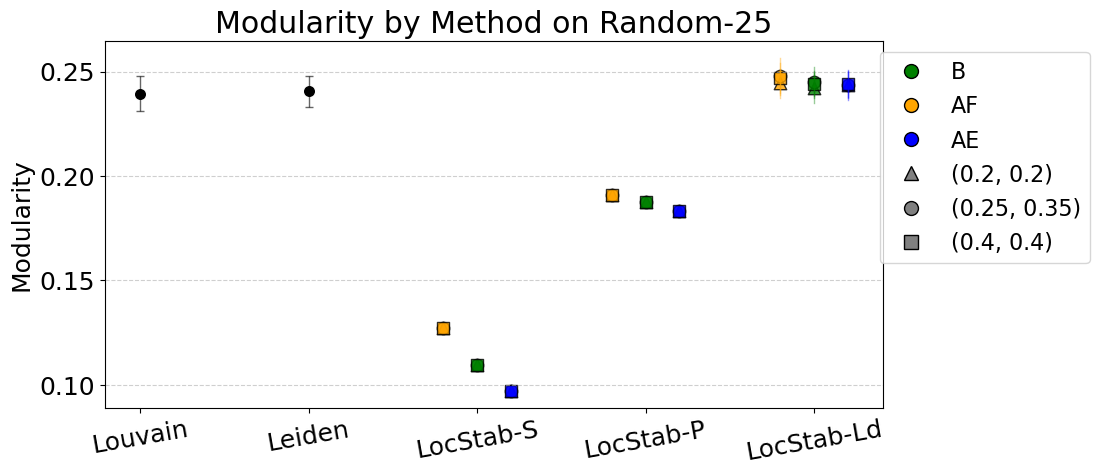

In [8]:
import ast
import numpy as np

def try_parse_tuple(x):
    # Handle actual tuples or lists
    if isinstance(x, (tuple, list)) and len(x) == 2:
        return (float(x[0]), float(x[1]))

    # Handle strings like '(0.85, 0.05)'
    if isinstance(x, str) and x.startswith('('):
        try:
            parsed = ast.literal_eval(x)
            if isinstance(parsed, (tuple, list)) and len(parsed) == 2:
                return (float(parsed[0]), float(parsed[1]))
        except Exception:
            pass

    # Handle known invalids like 'nan', 'n.A.', empty string, etc.
    return (np.nan, 0.0)

def normalize_score_column(df, score_cols):
    for col in score_cols:
        df[col] = df[col].apply(try_parse_tuple)
    return df
def plot_and_save(dfs,labels, dataset, score, save_path= None):
    for i in range(len(dfs)):
        dfs[i].replace("n.A.", np.nan, inplace= True)
        dfs[i] = normalize_score_column(dfs[i], [score])

    fig, ax = plot_custom_thresholds_with_louvain_leiden(
    dfs=dfs,
    labels=labels,
    dataset_name=dataset,
    score_col=score)
    if save_path:
        plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
        print(f"Figure saved as {save_path}")
    plt.show()
for df in dfs:
    df.replace("n.A.", np.nan, inplace=True)
    df.replace("25 random communities", "Random-25",inplace=True)

score_cols = ['Rand Index', 'Modularity']
dfs = [normalize_score_column(df, score_cols) for df in dfs]

# Then call your plotting
for Dataset in ['Karate Club', 'Jazz', 'Cora', 'Random-25']:
    for score in score_cols:
        plot_and_save(
            dfs, labels, Dataset, score,
            save_path=f'/Users/User/Downloads/local-popular-main-final/noylim/Stable/community/{Dataset}-{score}.png'
        )

In [10]:
import ast
import numpy as np
import pandas as pd

# Example: dfs = [df1, df2, df3]

all_values = []

for df in dfs:
    col = 'Rand Score with initial clustering'
    if col in df.columns:
        values = df[col].apply(
            lambda x: ast.literal_eval(x)[0] if isinstance(x, str) and x.startswith('(')
            else x[0] if isinstance(x, (tuple, list))
            else float('nan')
        )
        all_values.extend(values.dropna().tolist())

# Convert to numpy array for convenience
all_values = np.array(all_values)

# Compute min, max, and average, ignoring NaNs
min_val = np.nanmin(all_values)
max_val = np.nanmax(all_values)
avg_val = np.nanmean(all_values)

print(f"Min: {min_val}")
print(f"Max: {max_val}")
print(f"Average: {avg_val}")


Min: 0.3356719463025724
Max: 0.9492882395278066
Average: 0.6917916004318998


In [9]:
for i,df in enumerate(dfs):
    df.to_csv(f"/Users/User/Downloads/local-popular-main-final/noylim/Stable/community/data-{i}")